
#**Trabajo**

Desarrollo de tres modelos de Machine Learning —CatBoost, Random Forest y una red neuronal multicapa (MLP)— con el propósito de compararlos con un modelo de regresión logística. El objetivo es identificar cuál de estos modelos ofrece el mejor desempeño para predecir qué clientes están interesados en contratar una póliza de seguros, y así minimizar, en la medida de lo posible, la pérdida de clientes potenciales.

# **Librerias**

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
import shap
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

#**Datos**

###**Descripción del dataset**

Dataset Obtenido de: https://www.kaggle.com/datasets/arashnic/imbalanced-data-practice

**Objetivo:**

Una aseguradora busca construir un modelo predictivo que permita anticipar si un cliente estaría interesado en contratar un seguro de vehículos.  

**Datos demográficos**

El conjunto de datos **clientes_autos** contiene un total de **382,154 registros**, incluyendo información demográfica, historial de seguros, y de características de los vehículos de los clientes.

- **Sexo**: Género del cliente.
- **Edad (Age)**: Edad del cliente (entre 20 y 85 años, media de 38.54 años).
- **Tipo de código de región**: Clasificación geográfica de la residencia del cliente.

**Información sobre vehículos:**
- **Vehicle_Age**: Edad/antigüedad del vehículo, clasificada en tres categorías:
  - `< 1 Year` (Menos de 1 año)
  - `1-2 Year` (Entre 1 y 2 años)
  - `> 2 Years` (Más de 2 años)
- **Vehicle_Damage**: Indica si el vehículo ha sufrido daños anteriormente (1 = Sí, 0 = No).

**Historial de seguros:**
- **Previously_Insured**: Variable booleana que indica si el cliente ya contaba con un seguro previamente (1 = Sí, 0 = No).
- **Vintaje**: Dias que ha estado asegurado, hasta hoy.

**Información de póliza **
- **Policy_Sales_Channel**: Canal de abastecimiento o medio por el cual se contactó al cliente (valores entre 1 y 163).
- **Annual_Premium**: Valor de la prima anual del seguro, con montos entre 2,630 y 540,165 unidades monetarias, y una media de 30,711.27.


##**Variable Objetivo (Y)**

La variable objetivo (target) indica el interés del cliente en adquirir un seguro de vehículos:
- **0**: Cliente interesado en contratar un seguro de vehículos.
- **1**: Cliente no interesado en contratar un seguro de vehículos.

 ## **Variables Predictoras (X)**


| Variable             | Tipo de dato  | Descripción |
|----------------------|---------------|-------------|
| Previously_Insured   | Booleana       | Indica si el cliente ya contaba con un seguro previamente (1 = Sí, 0 = No). |
| Annual_Premium       | Numérica       | Monto anual de la prima del seguro. Rango entre 2,630 y 540,165 unidades monetarias. |
| Vehicle_Damage       | Booleana       | Indica si el vehículo ha sufrido daños anteriormente (1 = Sí, 0 = No). |
| Policy_Sales_Channel | Numérica       | Canal de abastecimiento o medio por el cual se contactó al cliente (valores entre 1 y 163). |
| Age                  | Numérica       | Edad del cliente, con valores entre 20 y 85 años (media de 38.54 años). |
| Vehicle_Age          | Categórica     | Antigüedad del vehículo, clasificada en tres rangos|






# **Análisis exploratorio**

In [3]:
#Cargamos el dataset
df=pd.read_csv('https://raw.githubusercontent.com/Motsof/Regresion/refs/heads/main/Datos/aug_train.csv')
#Vemos los primeros elementos del dataset
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [4]:
#Para una mejor visualización de los resultados cambiaremos el nombre de la columna "Response" por "Target"
#y la pondremos al inicio de la tabla
df.rename(columns={'Response':'Target'}, inplace=True)
df.drop('id',axis=1,inplace=True)
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Target
0,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [5]:
df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Target
count,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000
mean,38.545691,0.998108,26.406867,0.489182,30711.271362,111.939812,154.189429,0.163811
std,15.226897,0.043455,13.181241,0.499884,17061.595532,54.286511,83.735107,0.370104
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24546.000000,26.000000,81.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31692.000000,145.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39447.750000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                382154 non-null  object 
 1   Age                   382154 non-null  int64  
 2   Driving_License       382154 non-null  int64  
 3   Region_Code           382154 non-null  float64
 4   Previously_Insured    382154 non-null  int64  
 5   Vehicle_Age           382154 non-null  object 
 6   Vehicle_Damage        382154 non-null  object 
 7   Annual_Premium        382154 non-null  float64
 8   Policy_Sales_Channel  382154 non-null  float64
 9   Vintage               382154 non-null  int64  
 10  Target                382154 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 32.1+ MB


In [7]:
#Análisis de valores nulos
df.isna().mean()

,0
Gender,0.0
Age,0.0
Driving_License,0.0
Region_Code,0.0
Previously_Insured,0.0
Vehicle_Age,0.0
Vehicle_Damage,0.0
Annual_Premium,0.0
Policy_Sales_Channel,0.0
Vintage,0.0


In [8]:
#Verificamos que no haya registros duplicados
print(f'Hay {df.duplicated().sum()} filas duplicadas')

Hay 286 filas duplicadas


In [9]:
#Visualizamos los clientes que se encuentran interesados
df_0=df[df['Target']==0]
df_0.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Target
0,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [10]:
#Visualizamos los clientes que no están interesados
df_1=df[df['Target']==1]
df_1.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Target
9,Male,42,1,28.0,0,1-2 Year,Yes,27801.0,122.0,217,1
12,Male,33,1,28.0,0,< 1 Year,Yes,25434.0,122.0,165,1
14,Male,42,1,28.0,0,1-2 Year,Yes,38347.0,124.0,263,1
15,Male,45,1,41.0,0,1-2 Year,Yes,33303.0,26.0,155,1
21,Male,38,1,46.0,0,1-2 Year,Yes,2630.0,157.0,256,1


In [11]:
#Conteo de INTERESADOS
Target_0 =len(df[df['Target']==0])
print('Target_0=',Target_0)
#Conteo de NO INTERESADOS
Target_1 =len(df[df['Target']==1])
print('Target_1=',Target_1)

Target_0= 319553
Target_1= 62601


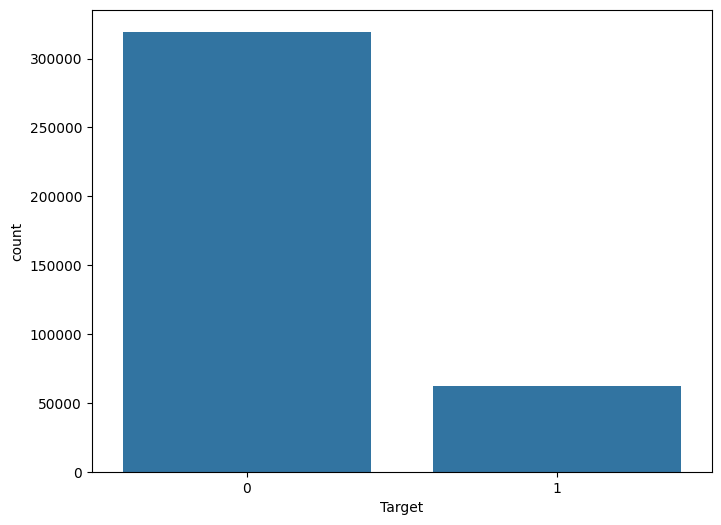

In [12]:
#Visualizamos los interesados (0) y no interesados (1) gráficamente
plt.figure(figsize=(8, 6))
sns.countplot(x='Target',data=df)
plt.show()

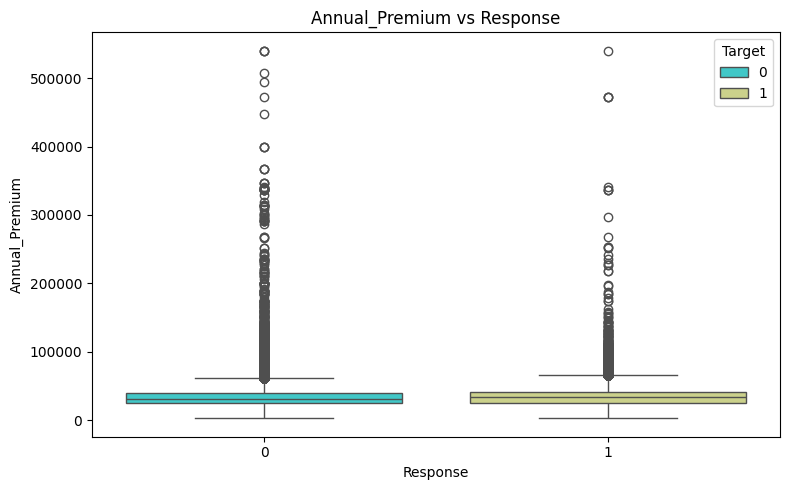

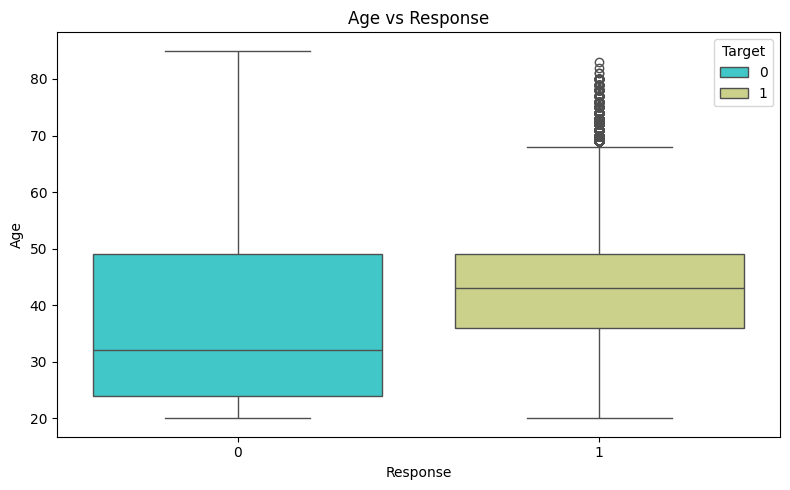

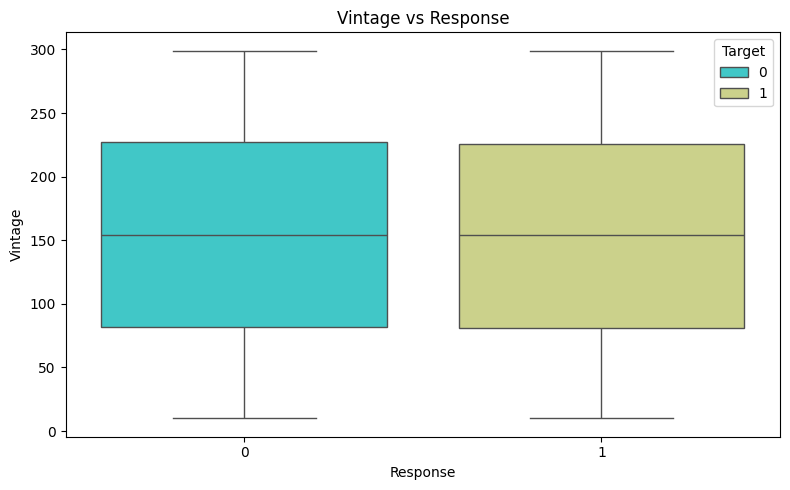

In [13]:
for col in ['Annual_Premium','Age','Vintage']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Target', y=col, data=df, palette='rainbow', hue='Target')
    plt.title(f'{col} vs Response')
    plt.xlabel('Response')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

In [14]:
#Se observa que 'Annual_Premium' tiene valores atipicos, por lo que los quitaremos
# Calculamos el IQR de Annual_Premium
Q1 = df['Annual_Premium'].quantile(0.25)
Q3 = df['Annual_Premium'].quantile(0.75)
IQR = Q3 - Q1

# Definimos el intervalo superior e inferior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Quitamos los outliers
df = df[(df['Annual_Premium'] >= lower_bound) & (df['Annual_Premium'] <= upper_bound)]

In [15]:
# Lista de las variables numericas del df
numerico = df.select_dtypes(include='number').columns

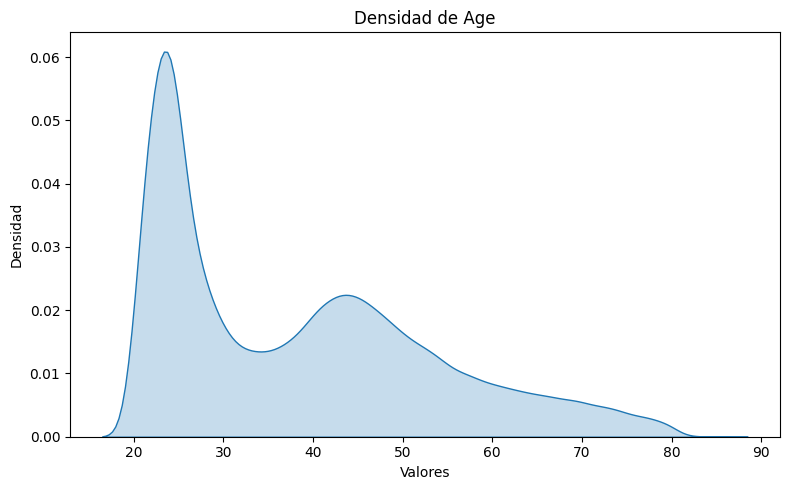

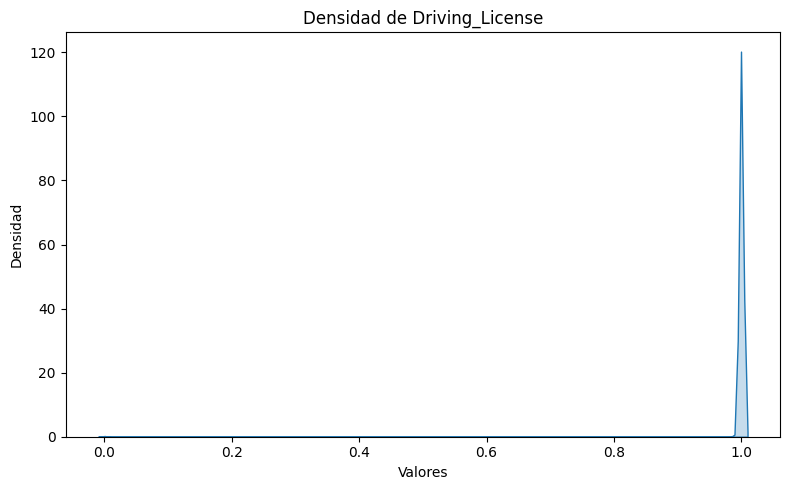

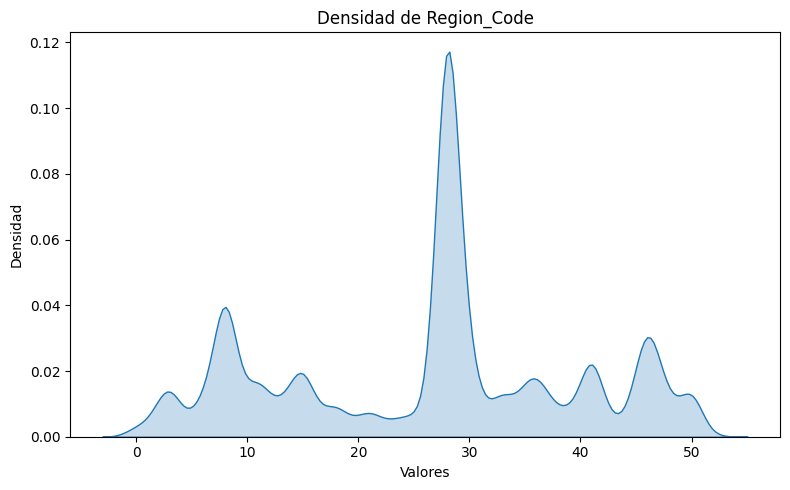

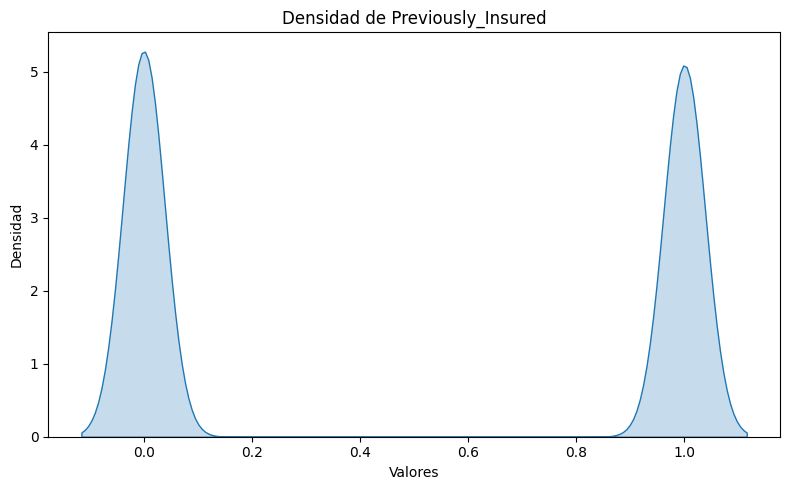

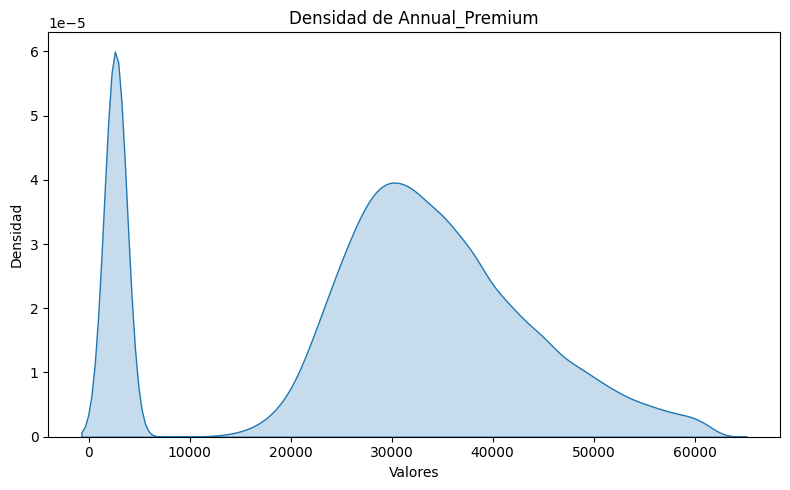

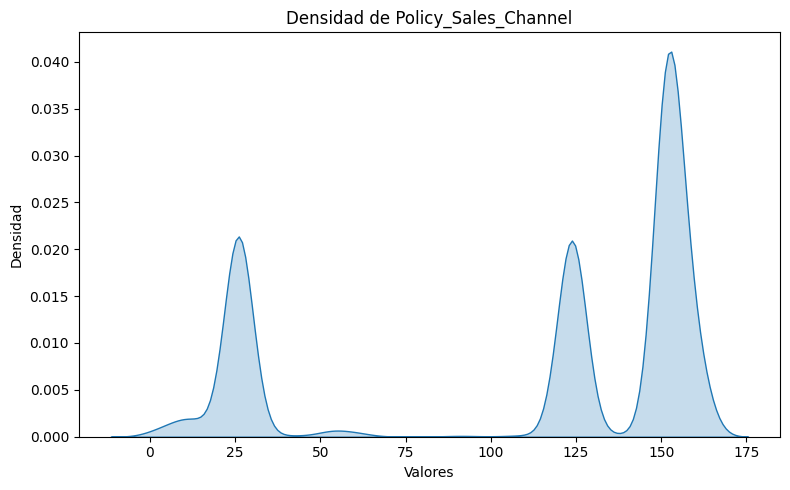

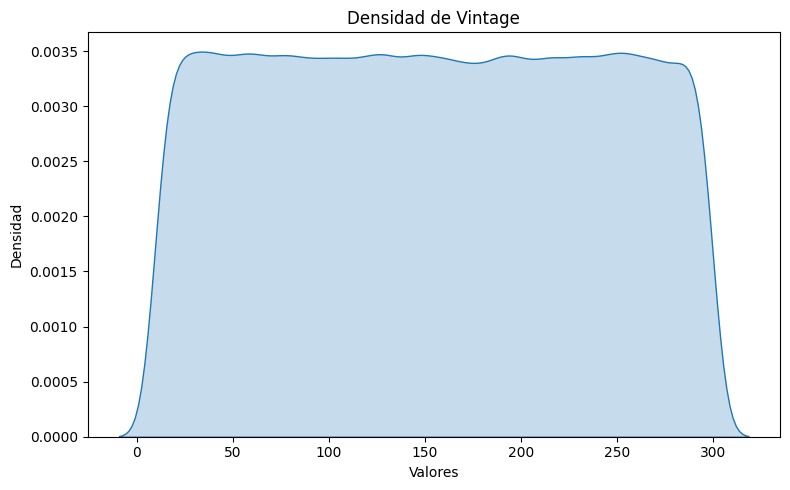

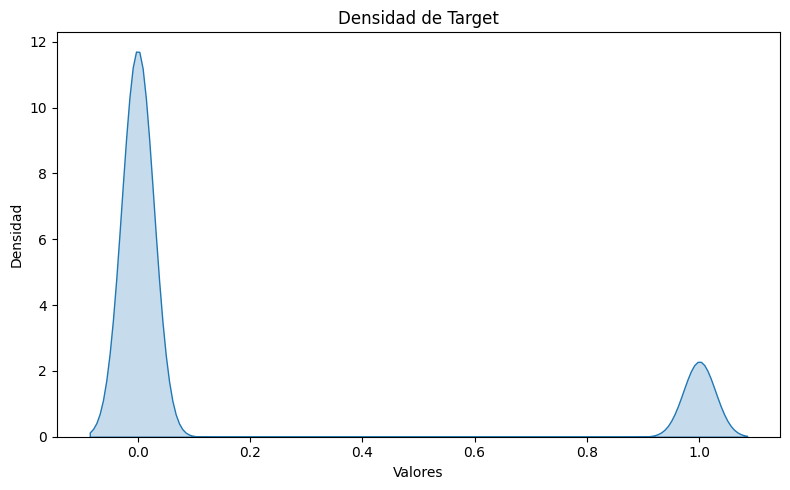

In [16]:
for col in numerico:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(x=df[col],fill=True)
    plt.title(f'Densidad de {col}')
    plt.xlabel("Valores")
    plt.ylabel("Densidad")
    plt.tight_layout()
    plt.show()


##Datos demográficos

In [17]:
#Las variables demográficas
dem=['Gender','Age']
dem

['Gender', 'Age']

In [18]:
#Conteo de los datos
for d in dem:
    print(f'---------Valores unicos de {d}---------')
    print(df[d].value_counts())
    print('\n')

---------Valores unicos de Gender---------
Gender
Male      199799
Female    171948
Name: count, dtype: int64


---------Valores unicos de Age---------
Age
24    25611
23    23957
25    20551
22    20445
21    15478
      ...  
81       49
82       31
83       22
84       14
85        9
Name: count, Length: 66, dtype: int64




In [19]:
#Porcentaje (decimal) de los datos respecto al total
for d in dem:
    print(f'---------Valores unicos de {d}---------')
    print(df[d].value_counts()/len(df))
    print('\n')

---------Valores unicos de Gender---------
Gender
Male      0.53746
Female    0.46254
Name: count, dtype: float64


---------Valores unicos de Age---------
Age
24    0.068894
23    0.064444
25    0.055282
22    0.054997
21    0.041636
        ...   
81    0.000132
82    0.000083
83    0.000059
84    0.000038
85    0.000024
Name: count, Length: 66, dtype: float64




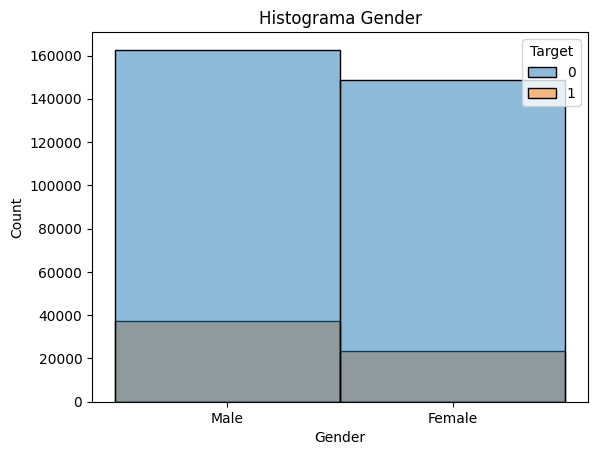

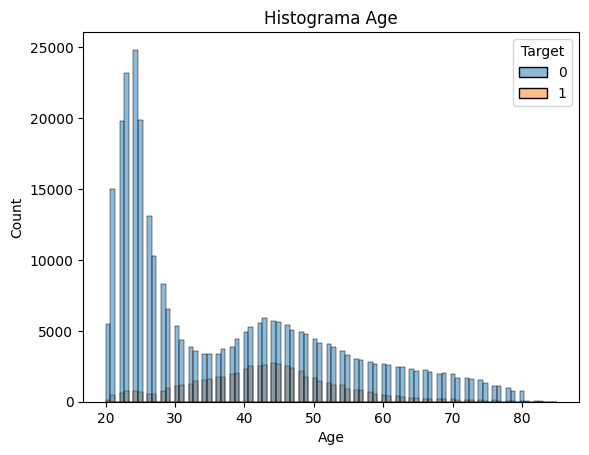

In [20]:
#Podemos observar que la cantidad de personas interesadas es muy proporcional en ambos casos entre hombres y mujeres.
#En la parte de edades podemos apreciar que la mayoría de cleintes interesados son jóvenes entre 20 a 30 años, mientras que los adultos entre 40 y 50 años no tienen interés.
#Por último, entre las regiones con mayor población se sigue teniendo un alto interés en el seguro en cuestión.
for d in dem:
    title = "Histograma " + d
    figsize=(10)
    sns.histplot(data= df, x=d, hue='Target').set(title=title)
    plt.show()

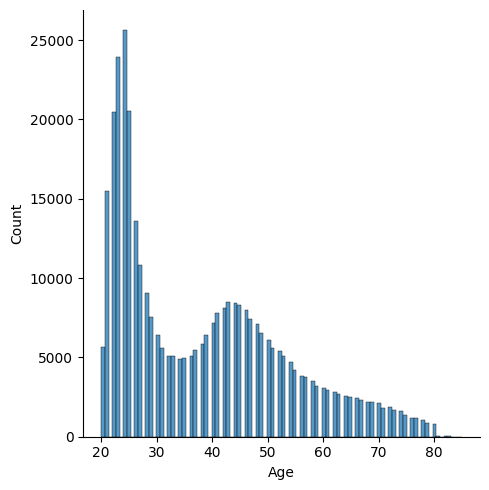

In [21]:
#Distribución de las Edades
#La edad oscila entre 25 y 85 años
sns.displot(df['Age'])
plt.show()

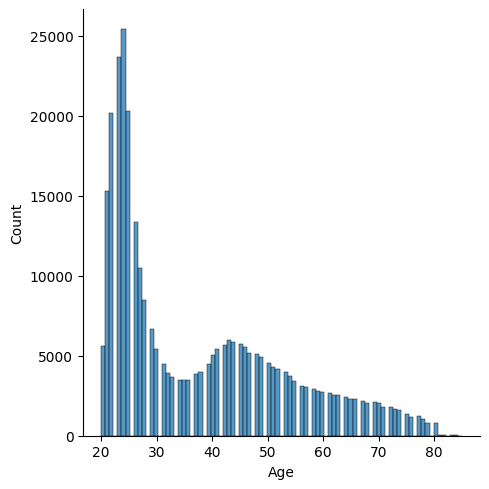

In [22]:
#Distribución de edades de las persona interesadas
#Entre más edad parece haber menos interés
sns.displot(df_0['Age'])
plt.show()

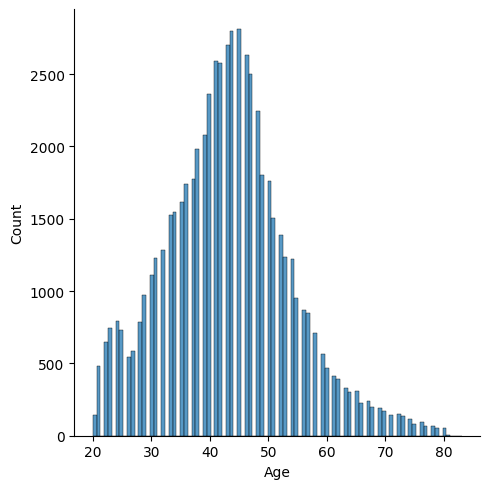

In [23]:
#Distribución de edades de las persona no interesadas
#Como se comento anteriormente, en las edades de adultos mayores se presenta un menor interés en la adquisición del seguro.
sns.displot(df_1['Age'])
plt.show()

Con lo anterior, se observa que la concentración de personas interesadas en un seguro para su vehículo se encuentra en un rango de edades de 20 a 30 años.
Además, la concentración de personas que NO están interesadas en un seguro para su vehículo se encuentra en un rango de edades de 40 a 50 años.

##Datos del vehículo

In [24]:
#Las variables vehiculares
vehicles=['Vehicle_Age','Vehicle_Damage']
vehicles

['Vehicle_Age', 'Vehicle_Damage']

In [25]:
#Conteo de los datos
for v in vehicles:
    print(f'---------Valores unicos de {v}---------')
    print(df[v].value_counts())
    print('\n')

---------Valores unicos de Vehicle_Age---------
Vehicle_Age
1-2 Year     194110
< 1 Year     162992
> 2 Years     14645
Name: count, dtype: int64


---------Valores unicos de Vehicle_Damage---------
Vehicle_Damage
No     193773
Yes    177974
Name: count, dtype: int64




In [26]:
#Porcentaje de los datos
for v in vehicles:
    print(f'---------Valores unicos de {v}---------')
    print(df[v].value_counts()/len(df))
    print('\n')

---------Valores unicos de Vehicle_Age---------
Vehicle_Age
1-2 Year     0.522156
< 1 Year     0.438449
> 2 Years    0.039395
Name: count, dtype: float64


---------Valores unicos de Vehicle_Damage---------
Vehicle_Damage
No     0.52125
Yes    0.47875
Name: count, dtype: float64




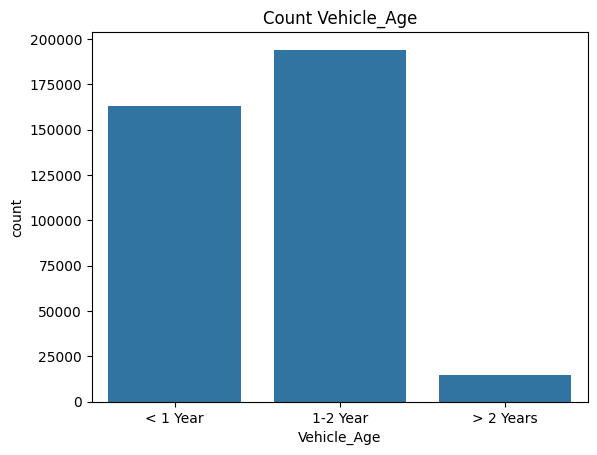

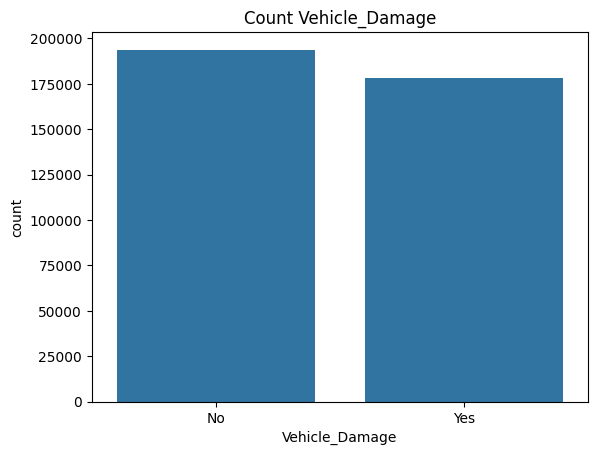

In [27]:
#Conteo de cada variable respecto al total
for v in vehicles:
    title = "Count " + v
    sns.countplot(data= df, x=v).set(title=title)
    plt.show()

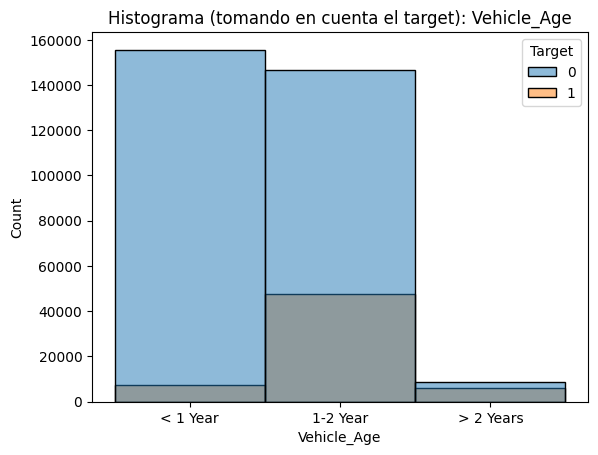

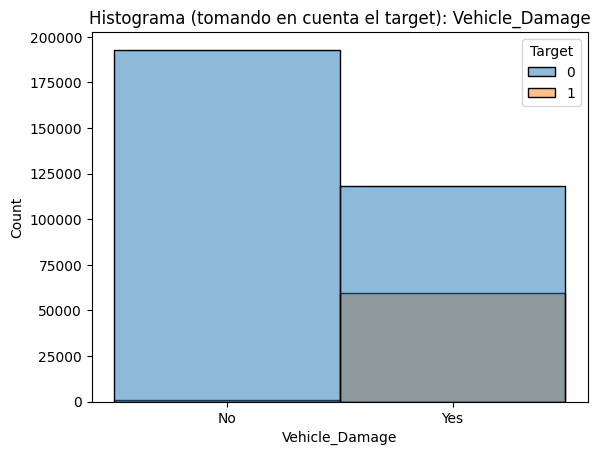

In [28]:
#Ahora visualizando tomando en cuenta el Target
for v in vehicles:
    title = "Histograma (tomando en cuenta el target): " + v
    sns.histplot(data= df, x=v, hue='Target').set(title=title)
    plt.show()

##Datos de la póliza

In [29]:
#Las variables sobre la póliza
policy=['Annual_Premium','Policy_Sales_Channel','Previously_Insured']
policy

['Annual_Premium', 'Policy_Sales_Channel', 'Previously_Insured']

In [30]:
#Porcentaje de los datos
for p in policy:
    print(f'---------Valores unicos de {p}---------')
    print(df[p].value_counts()/len(df))
    print('\n')

---------Valores unicos de Annual_Premium---------
Annual_Premium
2630.0     0.169137
38452.0    0.000126
45179.0    0.000121
36086.0    0.000108
38287.0    0.000105
             ...   
15696.0    0.000003
17327.0    0.000003
54769.0    0.000003
54899.0    0.000003
60983.0    0.000003
Name: count, Length: 41755, dtype: float64


---------Valores unicos de Policy_Sales_Channel---------
Policy_Sales_Channel
152.0    0.362276
26.0     0.210390
124.0    0.191698
160.0    0.055836
156.0    0.027008
           ...   
149.0    0.000003
143.0    0.000003
50.0     0.000003
141.0    0.000003
41.0     0.000003
Name: count, Length: 156, dtype: float64


---------Valores unicos de Previously_Insured---------
Previously_Insured
0    0.509225
1    0.490775
Name: count, dtype: float64




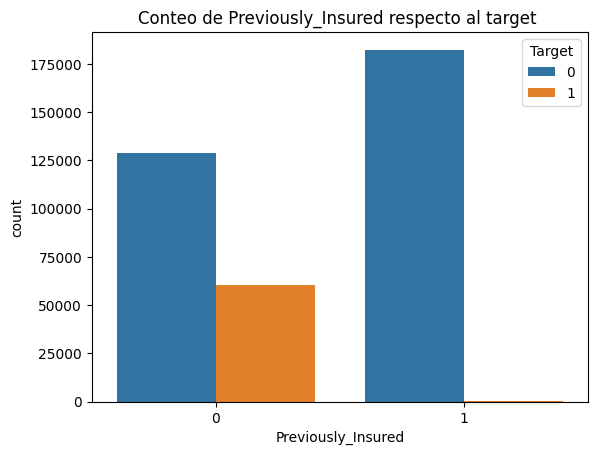

In [31]:
#Conteo de Previously Insured tomando en cuenta la varible objetivo
title = "Conteo de Previously_Insured respecto al target "
sns.countplot(data= df, x='Previously_Insured', hue='Target').set(title=title)
plt.show()

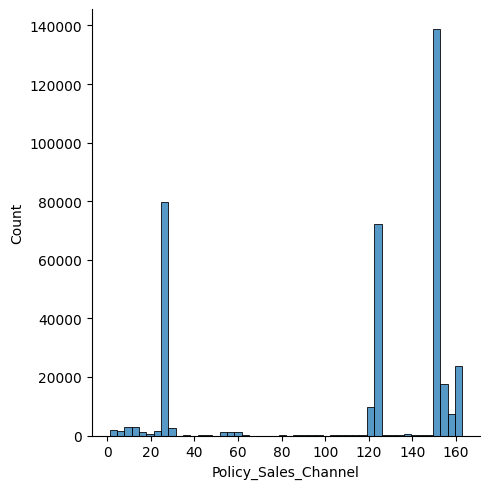

In [32]:
#Distribución de los canales de ventas de las pólizas
sns.displot(df['Policy_Sales_Channel'])
plt.show()

#Preprocesamiento de los datos

In [33]:
# convirtiendo 'Gender' y 'Vehicle_Damage' a dummies
df2= pd.get_dummies(df, columns=['Gender', 'Vehicle_Damage', 'Vehicle_Age'], drop_first=True)

In [34]:
#Dummies a numericas
for col in df2.select_dtypes(include='bool').columns:
    df2[col] = df2[col].astype('int64')

In [35]:
#Promedio de las variables en función del target
df2.groupby(['Target']).mean()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Damage_Yes,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
Target,,,,,,,,,,,
0,37.507252,0.997928,26.398818,0.585794,29230.978292,116.780347,154.265785,0.522685,0.379951,0.500016,0.028436
1,42.988418,0.999389,26.758034,0.002181,30354.379595,90.097282,153.827922,0.613432,0.986782,0.121867,0.095746


In [36]:
#Separamos los datos para las varibles independientes (X) y la depediente (Y)
X = df2.drop('Target', axis=1)
y = df2['Target']

In [37]:
# Separacion de df2 en los datos de entrenamiento en 80% y de prueba 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Es importante hacer un balanceo de las clases de la varible 'Target' para que el modelo no tengo sesgo en la clase mayoritaria. Donde en nuestro caso la clase mayoritaria es 0 por lo que se hara un sobremuestreo en los 1, pero solo en los datos de entrenamiento.

In [38]:
# Iniciamos smote
os = SMOTE(random_state=0,sampling_strategy=0.45)

# Aplicacion de OverSampling con SMOTE
X_train, y_train = os.fit_resample(X_train, y_train)

# Metodología

In [39]:
#correlación con respecto al target con pearson
correlation = (pd.DataFrame(df2.corr().Target))
correlation.sort_values(by='Target', ascending=False).style.background_gradient(cmap='coolwarm_r')

,Target
Target,1.000000
Vehicle_Damage_Yes,0.448483
Age,0.133532
Vehicle_Age_> 2 Years,0.127743
Gender_Male,0.067196
Annual_Premium,0.028383
Driving_License,0.012606
Region_Code,0.010002
Vintage,-0.001931
Policy_Sales_Channel,-0.182003


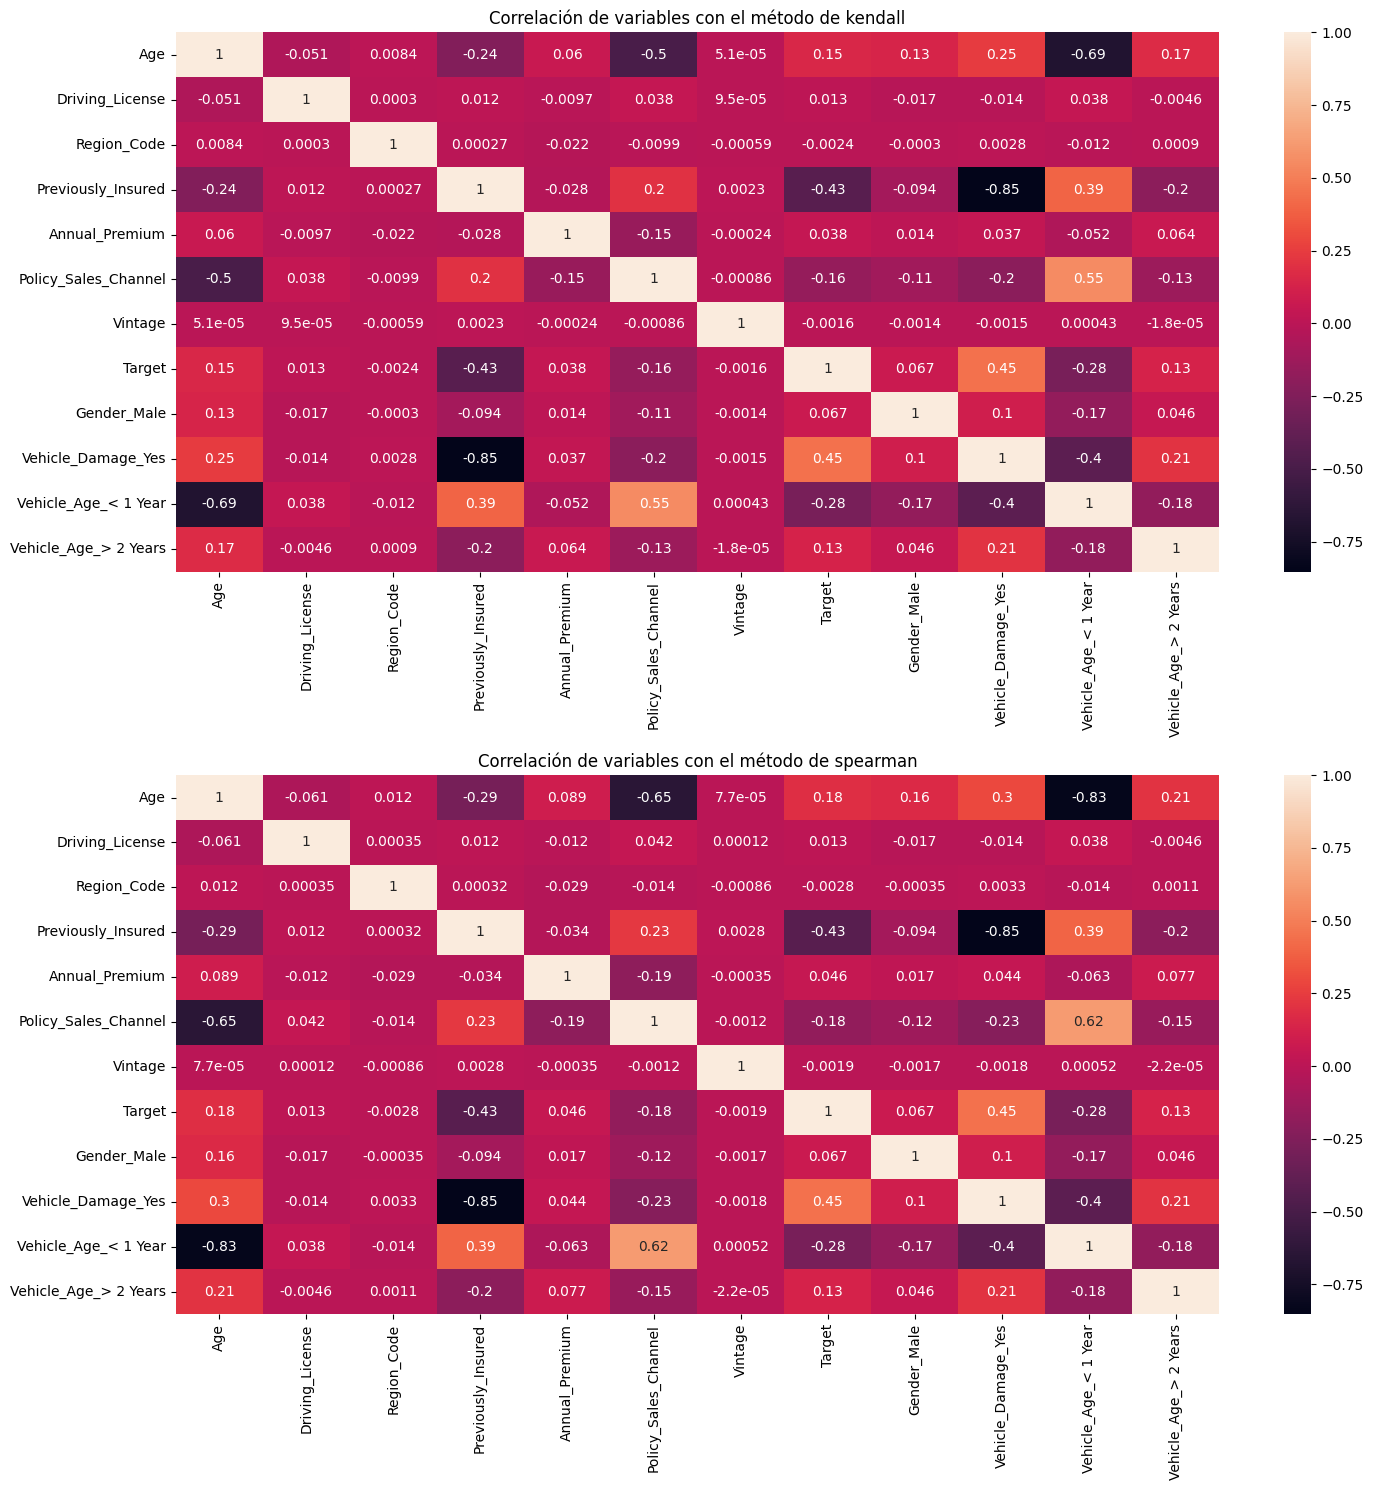

In [40]:
#graficamos la matriz de correlacion entera
plt.rcParams['figure.figsize'] = (15,15)
fig = plt.figure()
plt.gcf().subplots_adjust(wspace = 0, hspace = 0.3)

ax = fig.add_subplot(211)
sns.heatmap(df2.corr(method='kendall'), annot=True, ax=ax)
plt.title('Correlación de variables con el método de kendall')
plt.tight_layout()
ax = fig.add_subplot(212)
sns.heatmap(df2.corr(method='spearman'), annot=True, ax=ax)
plt.title('Correlación de variables con el método de spearman')
plt.tight_layout()

In [41]:
#Agegamos la constante a los datos de entrenamiento
X_constant = sm.add_constant(X_train)

#Calculamos el VIF
vif = [variance_inflation_factor(X_constant.values, i)
       for i in range(X_constant.shape[1])]

#Imprimimos los valores VIF
print(f'---------Valores VIF---------')
print(pd.Series(vif, index=X_constant.columns))
print('\n')

---------Valores VIF---------
const                    714.162672
Age                        2.634167
Driving_License            1.006587
Region_Code                1.002678
Previously_Insured         4.085809
Annual_Premium             1.027942
Policy_Sales_Channel       1.569754
Vintage                    1.000031
Gender_Male                1.017868
Vehicle_Damage_Yes         4.122578
Vehicle_Age_< 1 Year       2.931855
Vehicle_Age_> 2 Years      1.062744
dtype: float64




Dado el analisis de la correlacion y del VIF, mostro que las varibles Vehicle_Damage_Yes  y Previously_Insured  se considera colinealeales; por loq ue bastaría con eliminar Previously_Insured, para quitar la colinealidad.

Esto es lógico ya que quienes estuvieron asegurados, pudieron tuvier un accidente. Lo que puede denotar una mala experiencia con su anterior aseguradora.

In [42]:
#Por lo que quitamos esa varible en nuestros datos
X_constant.drop('Previously_Insured',axis=1,inplace=True)
X_test.drop('Previously_Insured',axis=1,inplace=True)
X_train.drop('Previously_Insured',axis=1,inplace=True)

# Regresión Logistica

In [43]:
#Corremos el Modelo de Regresion Logistica
logit_model=sm.Logit(y_train,X_constant)

result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.376203
         Iterations 8
                            Results: Logit
Model:                 Logit             Method:            MLE        
Dependent Variable:    Target            Pseudo R-squared:  0.393      
Date:                  2025-06-10 16:59  AIC:               271723.2045
No. Observations:      361110            BIC:               271841.9708
Df Model:              10                Log-Likelihood:    -1.3585e+05
Df Residuals:          361099            LL-Null:           -2.2366e+05
Converged:             1.0000            LLR p-value:       0.0000     
No. Iterations:        8.0000            Scale:             1.0000     
-----------------------------------------------------------------------
                       Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
const                 -1.7467   0.1355  -12.8897 0.0000 -2.0122

 Información General del Modelo

* **Pseudo-𝑅²**: **0.393**
  El modelo explica aproximadamente el **39.3 %** de la variabilidad en la variable dependiente.

* **Log-Likelihood (LL)**: **-135 850**
  Un LL muy negativo indica que el ajuste no es perfecto pero es lo esperado en modelos con datos complejos o numerosos parámetros.
  **Cuanto más cercano a 0**, mejor sería el ajuste.

* **AIC**: **271 723.2**

* **BIC**: **271 842.0**
  Ambos criterios balancean calidad de ajuste y penalización por número de parámetros; valores menores indican un modelo preferible.

* **LLR p-value**: **0.0000**
  El modelo completo es estadísticamente significativo.


In [44]:
#Realizamos las predicciones del modelo con nuestros datos de prueba, donde nos dara probabilidades
y_pred_prob = result.predict(sm.add_constant(X_test))

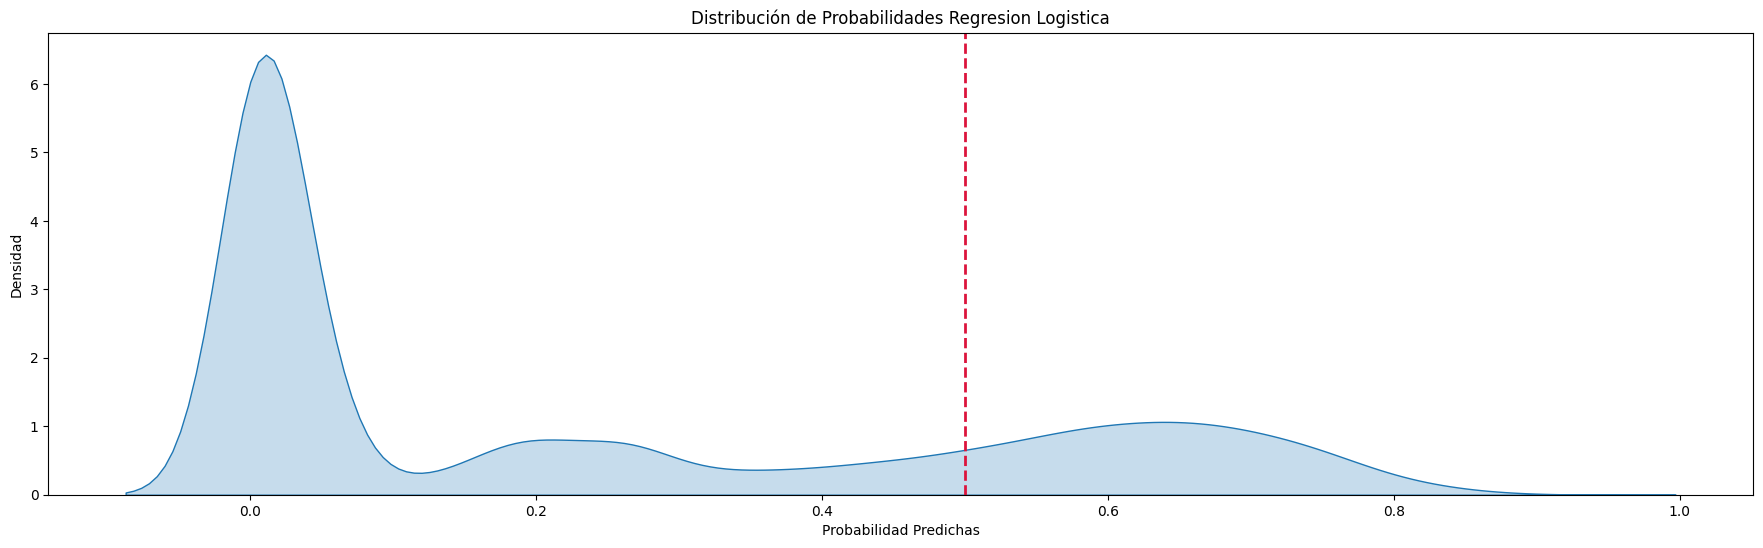

In [45]:
# Distribucion de las probabilidades generadas por el modelo con los datos de prueba, con un corte en 0.5
plt.figure(figsize=(22, 6))
sns.kdeplot(y_pred_prob,fill=True)
plt.axvline(x=0.5, color='crimson', linestyle='--', linewidth=2,label='Umbral 0.50')
plt.title('Distribución de Probabilidades Regresion Logistica')
plt.xlabel('Probabilidad Predichas')
plt.ylabel('Densidad')
plt.show()

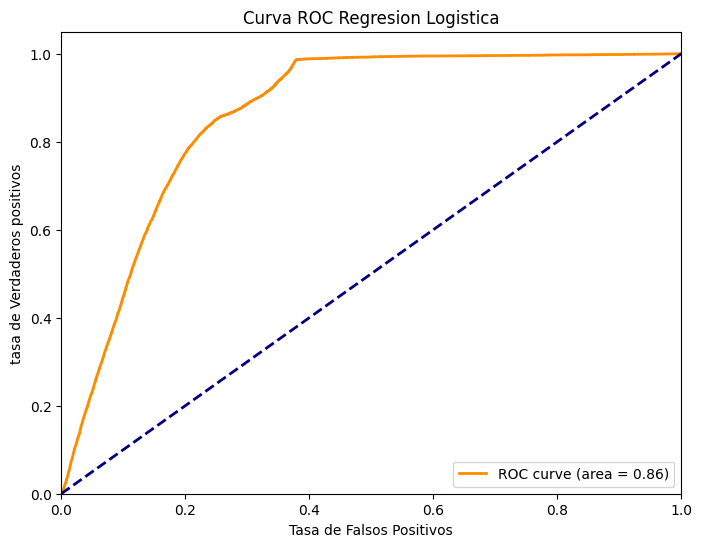

In [46]:
#Graficamos la curva ROC con el valor de AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('tasa de Verdaderos positivos')
plt.title('Curva ROC Regresion Logistica')
plt.legend(loc="lower right")
plt.show()

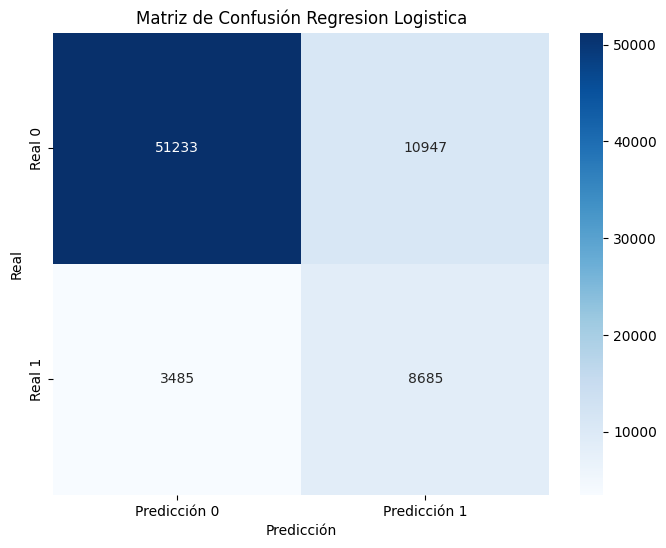

In [47]:
#Obtenemos nuestros predictores (0 o 1) con base en las probabilidades de la varible anterior. Con umbral de corte de 0.5, es decir si la probabilida es <0.5 se clasificará como  0 y si >= 0.5 sera un 1
y_pred = (y_pred_prob >= 0.5).astype(int)

#Calculo de la matriz de confusion
cm = confusion_matrix(y_test, y_pred)
#Grafico de la Matriz de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicción 0', 'Predicción 1'],yticklabels=['Real 0', 'Real 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Regresion Logistica')
plt.show()

In [48]:
#Obtenemos las metricas mas importantes
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88     62180
           1       0.44      0.71      0.55     12170

    accuracy                           0.81     74350
   macro avg       0.69      0.77      0.71     74350
weighted avg       0.86      0.81      0.82     74350



# CatBoost

In [49]:
#creamos una copia del df
df_3 = df.copy()

In [50]:
#Se quita la varible por el analisis de VIF
df_3.drop('Previously_Insured',axis=1,inplace=True)

In [51]:
# Separamos el df_3 en entrenamiento en 70%, 10% en validacion y 20% los de test

X3 = df_3.drop('Target', axis=1)
y3 = df_3['Target']

X_train_cat, X_temp_cat, y_train_cat, y_temp_cat = train_test_split(X3, y3, test_size=0.3, random_state=42)
X_val_cat, X_test_cat, y_val_cat, y_test_cat = train_test_split(X_temp_cat, y_temp_cat, test_size=2/3, random_state=42)

print(f'Tamaño del conjunto de entrenamiento: {X_train_cat.shape[0]}')
print(f'Tamaño del conjunto de validación: {X_val_cat.shape[0]}')
print(f'Tamaño del conjunto de prueba: {X_test_cat.shape[0]}')

Tamaño del conjunto de entrenamiento: 260222
Tamaño del conjunto de validación: 37175
Tamaño del conjunto de prueba: 74350


In [52]:
#Creamos el modelo de CatBoost
modelo_cat = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    loss_function='Logloss',
    eval_metric='Precision',
    random_seed=42,
    cat_features=['Gender', 'Vehicle_Damage', 'Vehicle_Age'],
    verbose=200,
    auto_class_weights='Balanced',
    use_best_model=True,
    early_stopping_rounds=50
    )

In [53]:
#Ajustamos el modelo a nuestros datos de entrenamiento y validación
modelo_cat.fit(X_train_cat, y_train_cat,eval_set=(X_val_cat, y_val_cat))

0:	learn: 0.7661251	test: 0.7704080	best: 0.7704080 (0)	total: 267ms	remaining: 4m 27s
200:	learn: 0.7905407	test: 0.7908526	best: 0.7910752 (171)	total: 56.6s	remaining: 3m 44s
400:	learn: 0.7974269	test: 0.7931987	best: 0.7933082 (398)	total: 1m 54s	remaining: 2m 51s
600:	learn: 0.8021220	test: 0.7954348	best: 0.7955891 (596)	total: 2m 51s	remaining: 1m 53s
800:	learn: 0.8063479	test: 0.7968319	best: 0.7969140 (795)	total: 3m 49s	remaining: 56.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7971076592
bestIteration = 822

Shrink model to first 823 iterations.


In [54]:
#Obtenemos las probabilidades predichas por el modelo de los datos de test
proba_test_cat = modelo_cat.predict_proba(X_test_cat)[:, 1]

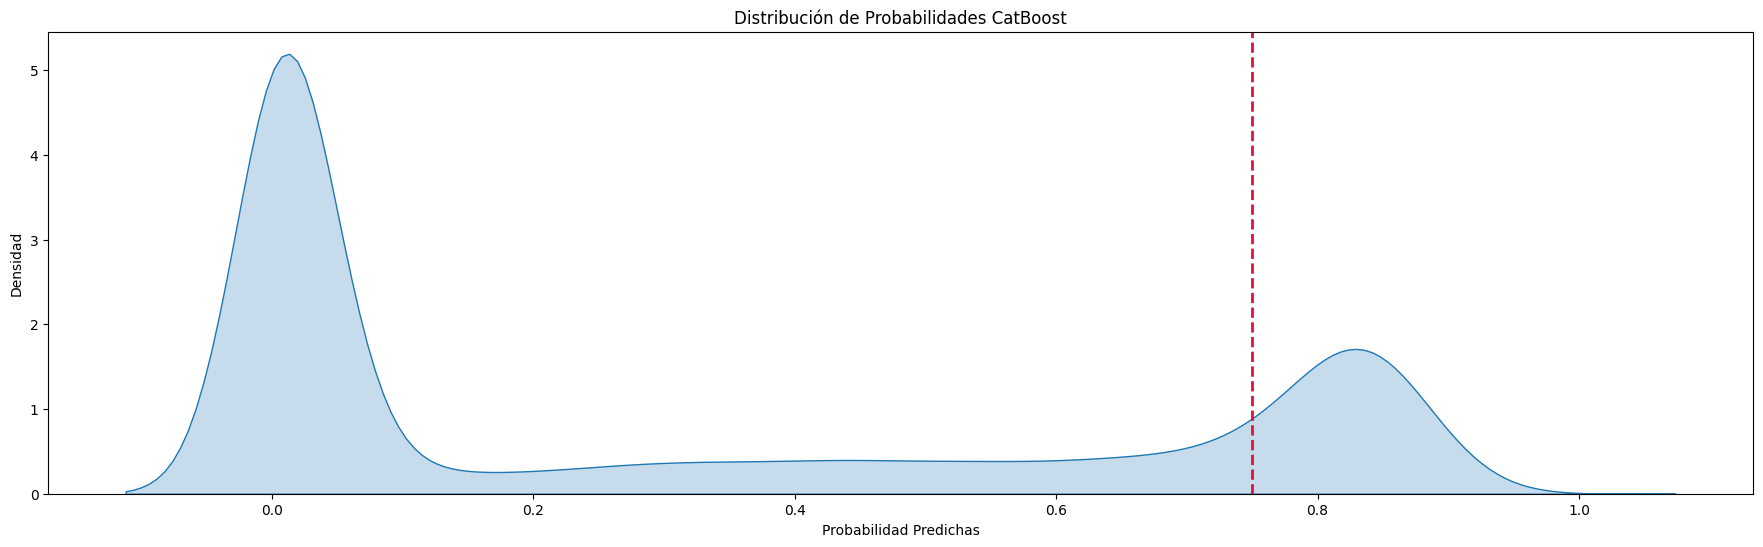

In [55]:
# Distribucion de las probabilidades generadas por el modelo con los datos de prueba, con un corte en 0.5
plt.figure(figsize=(22, 6))
sns.kdeplot(proba_test_cat,fill=True)
plt.axvline(x=0.75, color='crimson', linestyle='--', linewidth=2,label='Umbral 0.75')
plt.title('Distribución de Probabilidades CatBoost')
plt.xlabel('Probabilidad Predichas')
plt.ylabel('Densidad')
plt.show()

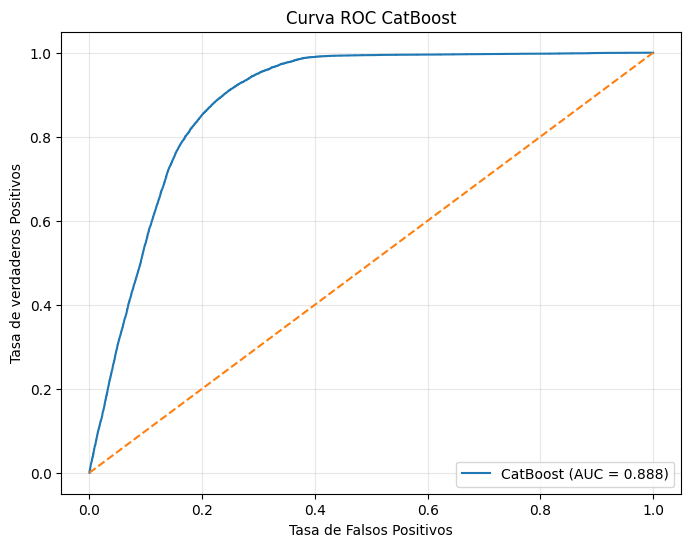

In [56]:
#calculamos la ROC
fpr, tpr, thr = roc_curve(y_test_cat, proba_test_cat)
roc_auc = auc(fpr, tpr)
#Graficamos la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"CatBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de verdaderos Positivos")
plt.title("Curva ROC CatBoost")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

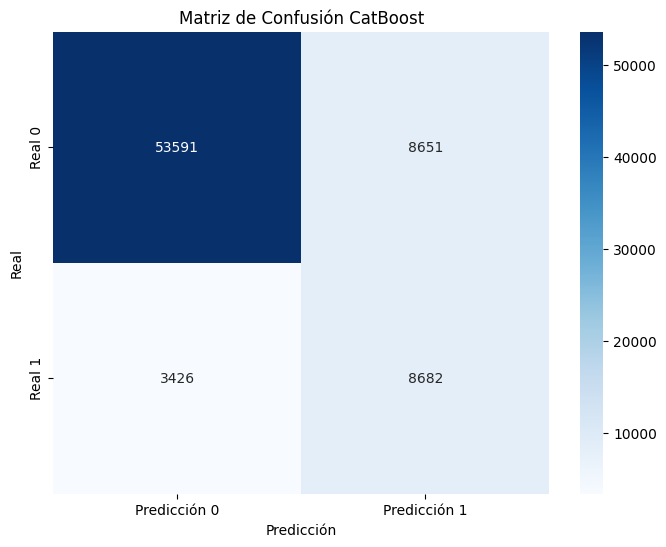

In [57]:
#Obtenemos las predicciones (0,1) para un umbral ajustable
y_pred_cat = (proba_test_cat >= 0.75).astype(int)
#Calculamos la matriz de confusión
cm = confusion_matrix(y_test_cat, y_pred_cat)
#Graficamos la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicción 0', 'Predicción 1'],yticklabels=['Real 0', 'Real 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión CatBoost')
plt.show()

In [58]:
#Obtenemos las metricas mas importantes
print(classification_report(y_test_cat, y_pred_cat))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90     62242
           1       0.50      0.72      0.59     12108

    accuracy                           0.84     74350
   macro avg       0.72      0.79      0.74     74350
weighted avg       0.87      0.84      0.85     74350



# Random Forest

In [59]:
# Creamos el modelo
modelo_bosque = RandomForestClassifier(n_estimators=100, random_state=42) # 100 arboles por defecto

In [60]:
#Ajuste del modelo para los datos de entrenamiento
modelo_bosque.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [61]:
#probabilidades predichas
y_pred_proba_bosque = modelo_bosque.predict_proba(X_test)[:, 1]

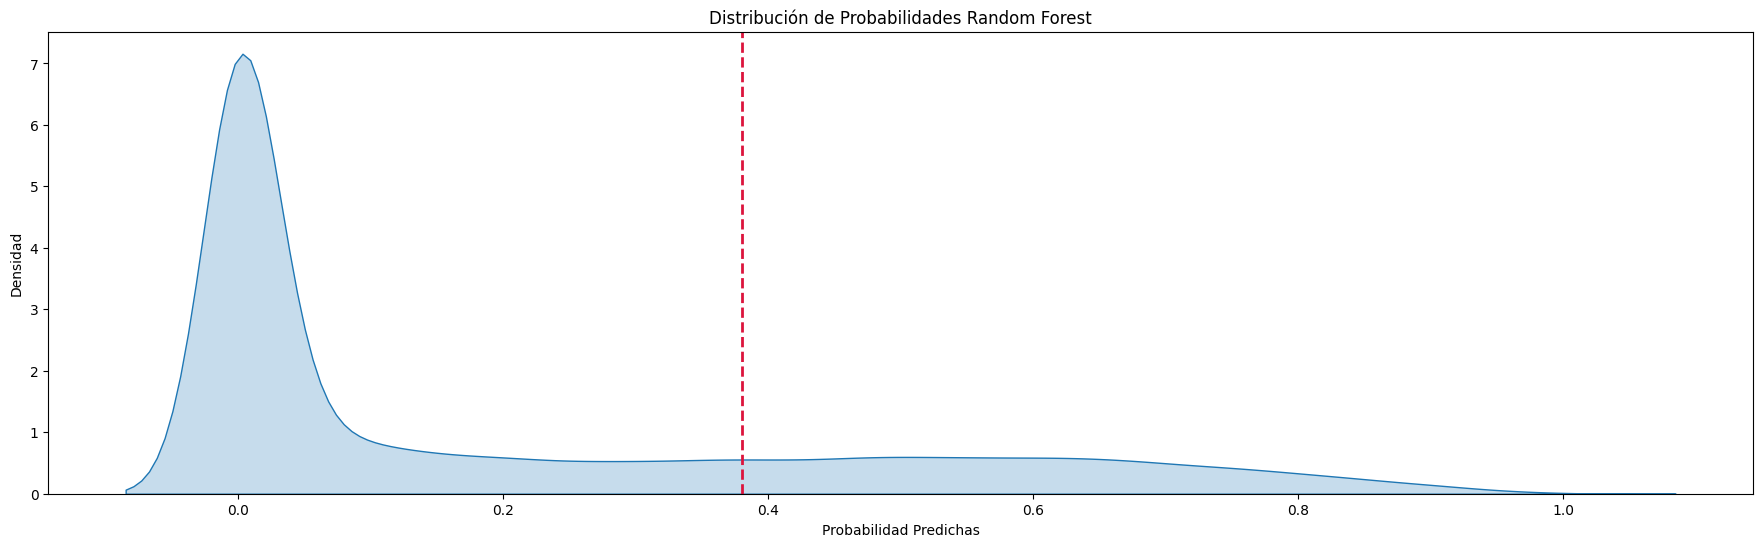

In [62]:
#Grafico de la distribucion de las probabilidades
plt.figure(figsize=(22, 6))
sns.kdeplot(y_pred_proba_bosque,fill=True)
plt.axvline(x=0.38, color='crimson', linestyle='--', linewidth=2,label='Umbral 0.38')
plt.title('Distribución de Probabilidades Random Forest')
plt.xlabel('Probabilidad Predichas')
plt.ylabel('Densidad')
plt.show()

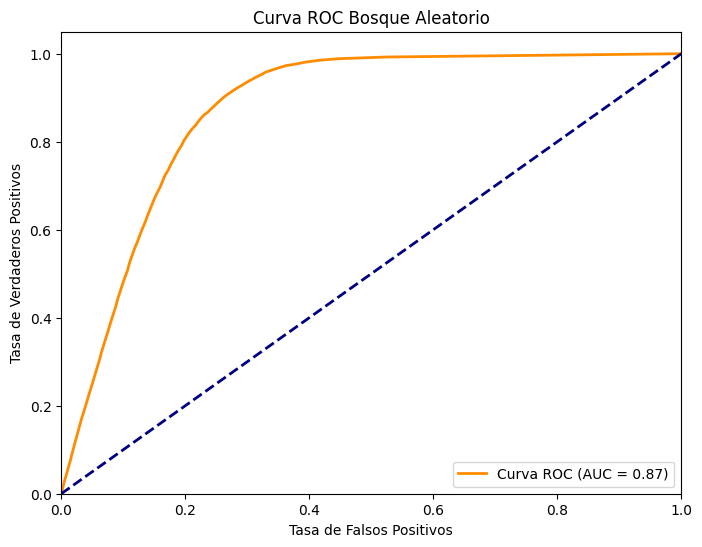

In [63]:
#Calculos para la ROC
fpr_bosque, tpr_bosque, thresholds_bosque = roc_curve(y_test, y_pred_proba_bosque)
roc_auc_bosque = auc(fpr_bosque, tpr_bosque)
#Grafico de lacurva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_bosque, tpr_bosque, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_bosque)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Bosque Aleatorio')
plt.legend(loc="lower right")
plt.show()

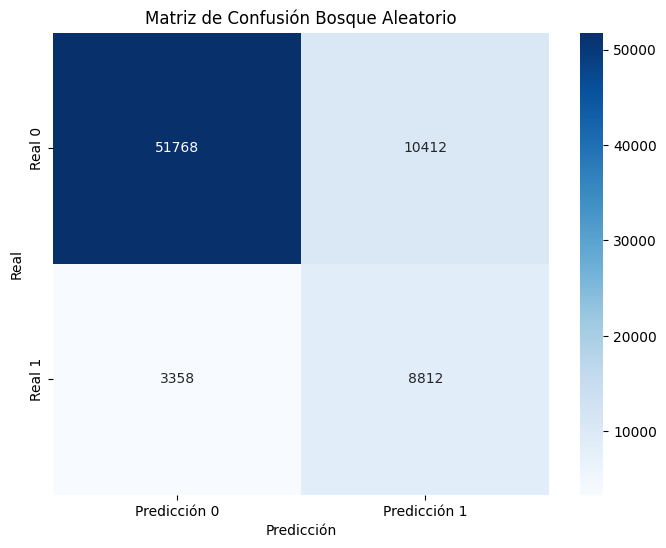

In [64]:
# Hacer predicciones con el modelo entrenado
y_pred_bosque = (y_pred_proba_bosque >= 0.38).astype(int)

# Crear la matriz de confusion
matriz_confusion_bosque = confusion_matrix(y_test, y_pred_bosque)
#Grafico de la matriz de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion_bosque, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicción 0', 'Predicción 1'], yticklabels=['Real 0', 'Real 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Bosque Aleatorio')
plt.show()

In [65]:
#Mostramos las metricas obtenidas del modelo
reporte_clasificacion_bosque = classification_report(y_test, y_pred_bosque)

print("Reporte de Clasificación (Bosque Aleatorio):")
print(reporte_clasificacion_bosque)

Reporte de Clasificación (Bosque Aleatorio):
              precision    recall  f1-score   support

           0       0.94      0.83      0.88     62180
           1       0.46      0.72      0.56     12170

    accuracy                           0.81     74350
   macro avg       0.70      0.78      0.72     74350
weighted avg       0.86      0.81      0.83     74350



#Redes Neuronales

In [66]:
#Creación del modelo, vamos a usar la función MLP debido a la naturaleza de nuestros datos a predecir, es decir la etiqueta (0,1)
mlp = MLPClassifier(hidden_layer_sizes=(40, ), activation='relu', max_iter=1000, random_state=42)

#Entrenamos el modelo
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(40,), max_iter=1000, random_state=42)

In [67]:
# Predecimos las probabilidades
y_pred_rn = mlp.predict_proba(X_test)[:,1]

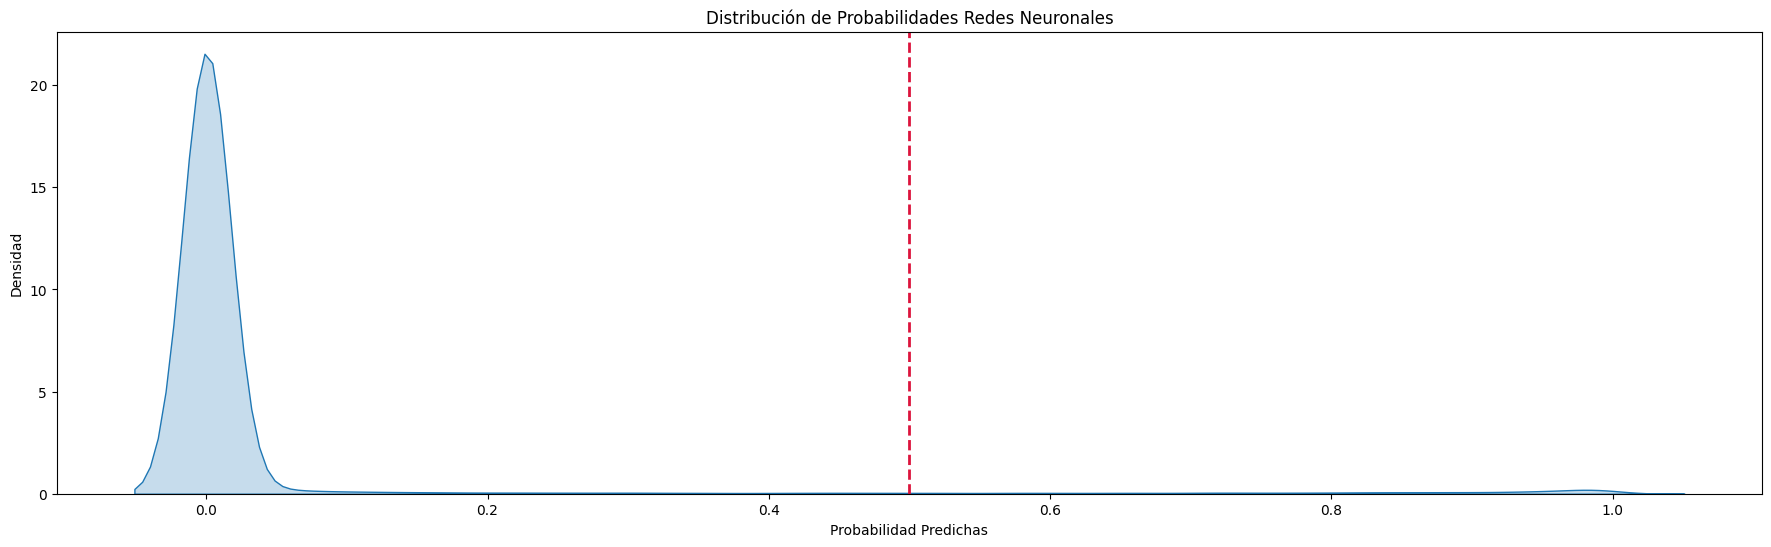

In [68]:
# Distribucion de las probabilidades generadas por el modelo con los datos de prueba, con un corte en 0.5
plt.figure(figsize=(22, 6))
sns.kdeplot(y_pred_rn,fill=True)
plt.axvline(x=0.5, color='crimson', linestyle='--', linewidth=2,label='Umbral 0.50')
plt.title('Distribución de Probabilidades Redes Neuronales')
plt.xlabel('Probabilidad Predichas')
plt.ylabel('Densidad')
plt.show()

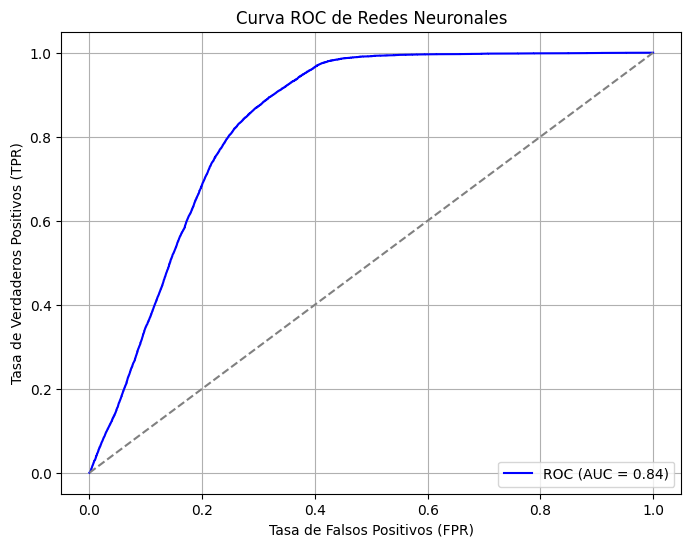

In [69]:
# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rn)
roc_auc = roc_auc_score(y_test, y_pred_rn)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Redes Neuronales')
plt.legend(loc='lower right')
plt.grid()
plt.show()

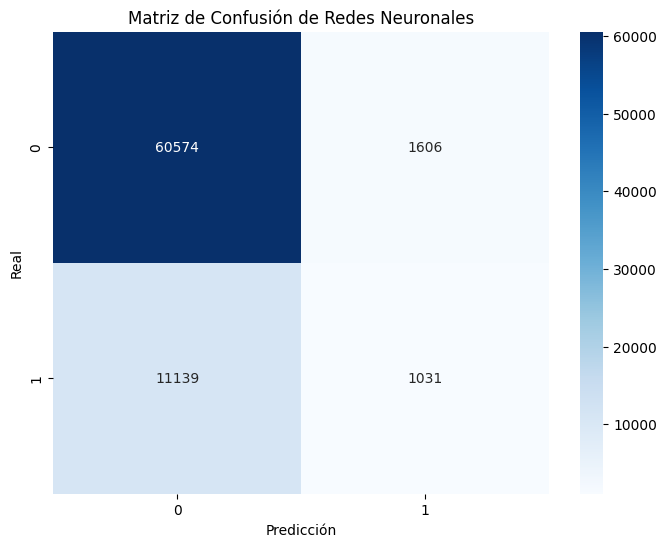

In [70]:
# Matriz de confusión
y_pred = (y_pred_rn >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
class_names = np.unique(y)

# Gráfico de calor (matriz de confusión)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión de Redes Neuronales')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [71]:
#Obtenemos las metricas mas importantes
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90     62180
           1       0.39      0.08      0.14     12170

    accuracy                           0.83     74350
   macro avg       0.62      0.53      0.52     74350
weighted avg       0.77      0.83      0.78     74350



# Conclusión para el mejor modelo

Tras un analisis exahustivo en la compracion de los 4 modelos (Logistica, CatBoost, Bosque y redes) se obtuvo  que el **modelo más robusto es CatBoost.**

Para esta decision se tomo en cuenta las dsitribucion de las probabilidades, la matriz de confusion, las metricas Recall, Precision (con ajuste al umbral en cada modelo) y AUC.

Para efectos de este analisis se cambio el threshold para hacer comparables las matrices, donde se trato de igualar los FN para cada modelo, con referencia a la de la regresion logistica en 0.5, por lo que el ajuste en catboost quedo en 0.75, en bosque aleatorio 0.38 y en redes fue imposible bajar los FN ya que esta esta muy sesgada a los 0, es decir, siempre va a detectar la clase 0, sin embargo siempre dara altos FN, lo que conlleva a que el modelo no tengo poder predictivo sobre la clase 1 (no interesados).

*Tambien se analizo que la problematica principal del dataset, es que nuestro modelo tiene que **minimizar los FP**, es decir maximizar la metrica de Presicion. Debido a que predecir erroneamente un cero (interesado) provocaria la perdida de clientes potenciales para le negocio.*


In [72]:
#Obtenemos las variables SHAP
explainer = shap.TreeExplainer(modelo_cat,feature_perturbation="tree_path_dependent")
shap_values = explainer(X_test_cat)

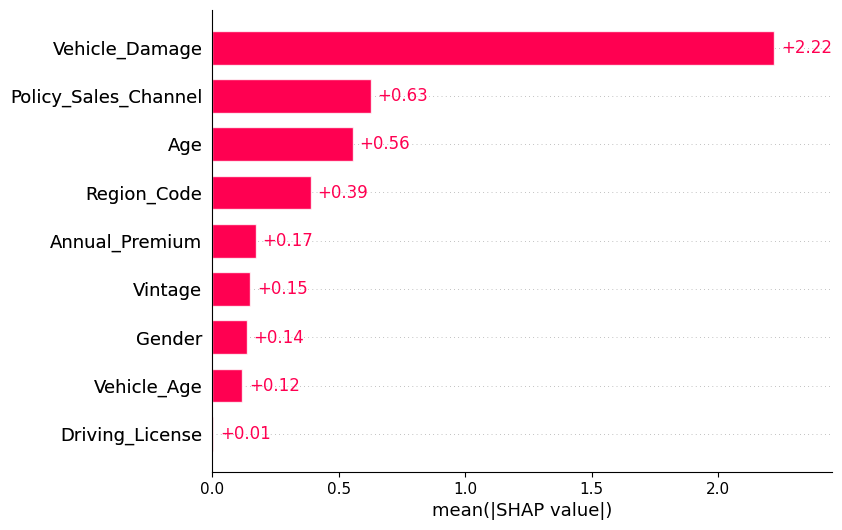

In [73]:
#graficamos los valores SHAP
shap.plots.bar(shap_values, max_display=15)
plt.show()

Para el modelo de CatBoost se observa que los log-odds, que sirve para mostrar cuánto sube/baja la probabilidad cuando cambia un feature.

1. **Vehicle_Damage = NO**

  SHAP ≈ 2.22 – Es, por mucho, el factor que más aumenta la probabilidad de que el cliente esté interesado. Si no ha tenido daños, el modelo asume que ve valor en asegurar su vehículo.
  Cuando es “Yes” (sí ha tenido daño), esta contribución es positiva, ayudando fuertemente a clasificar como no interesado (clase 1).

2. **Policy_Sales_Channel**

  SHAP ≈ 0.63 – Canal de ventas relevante: algunos canales elevan la conversión (por ejemplo, los digitales o los con mejor asesoría), Influyen.

3. **Age**

  SHAP ≈ 0.56 – La edad del cliente afecta significativamente. Ciertos rangos etarios, como adultos de mediana edad, probablemente tienen más consciencia del riesgo o mayor capacidad adquisitiva.

4. **Region_Code**

  SHAP ≈ 0.39 – La región geográfica aún modifica la predicción: en algunas zonas se contratan más seguros por cultura, riesgo vial o regulación.

5. **Annual_Premium**

  SHAP ≈ 0.17 – El monto de la prima cambia la decisión, aunque su efecto promedio es bajo. Importes muy altos podrían disuadir a ciertos clientes.

6. **Vintage**

  SHAP ≈ 0.15 – La antigüedad del cliente con la aseguradora afecta ligeramente. Usuarios nuevos o muy antiguos podrían comportarse distinto, pero el impacto es marginal.

7. **Gender = Male**

  SHAP ≈ 0.14 – Ser hombre tiene un efecto pequeño. Posiblemente ligado a diferencias de comportamiento o riesgo percibido, pero no es determinante.

8. **Vehicle_Age**

  SHAP ≈ 0.12 – La antigüedad del vehículo modifica la predicción de manera leve. Autos más viejos podrían percibir menos valor en un seguro, pero el efecto es limitado.

9. **Driving_License**

  SHAP ≈ 0.01 – Tener o no tener licencia apenas afecta la decisión. Probablemente porque casi todos los clientes tienen una, así que no discrimina. Lo que sugiere que la varibles se puede desechar sin problemas para analisis futuros.

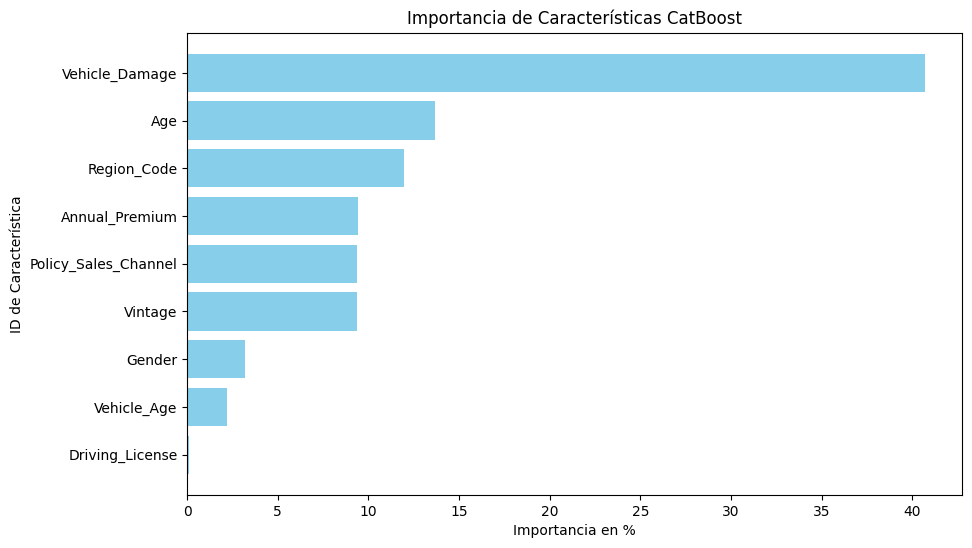

In [74]:
feature_importance = modelo_cat.get_feature_importance(prettified=True).sort_values(by='Importances', ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature Id'], feature_importance['Importances'], color='skyblue')
plt.xlabel('Importancia en %')
plt.ylabel('ID de Característica')
plt.title('Importancia de Características CatBoost')
plt.show()

Su interpretacion es que las variables que tienen un puntaje alto en get_feature_importance() son aquellas que se utilizaron muchas veces y, además, lograron divisiones eficientes para reducir la incertidumbre o el error del modelo, durante los splits en los árboles y no necesariaminete indica como se mueven los log-odds, lo cual si hace SHAP values.